In [14]:
## -*- coding: utf-8 -*-
"""
Created on Wed Feb  6 20:41:00 2019

@author: tobi carvalho et simon dufort-labbé
"""




import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive/')



class NN(object):
    
    def __init__(self,hidden_dims=(1024,2048),option=3, l_starting_rate=0.1,l_down_rate=0 ,L1reg=0,L2reg=0, momentum=0, dropout=0 , batch_size=100, max_iter=80,datapath="../content/gdrive/My Drive/Colab Notebooks/IFT6135/mnist.pkl.npy",model_path=None):
        
        """
        On définit les paramètres de départ:
        
        - Le nombre de couche est définie par la grosseur du tuple correspondant au nombre de neuronne dans chaque couche
        - Option définit qu'elle initialisation des poids est utilisé.
        - l_starting_rate le taux d'apprentissage à la première epoch
        - l_down_rate le paramètre de diminution du taux d'apprentissage selon l=l_0/(1+l_down_rate*epoch)
        - self.r est un raccourcie pour accéder au prédiction à l'extérieur de la classe
        - Le reste des paramètres est assez évident...
        
        """
        
        self.l_starting_rate=l_starting_rate
        self.l_down_rate=l_down_rate
        self.l_rate=l_starting_rate
        self.L1reg=L1reg
        self.L2reg=L2reg
        self.momentum=momentum
        self.dropout_rate=dropout
        self.max_iter=max_iter
        self.batch_size=batch_size
        
        self.tr, self.va, self.te = np.load(datapath)
        self.r=np.zeros(len(self.va[1]))
       
        self.n_hidden=len(hidden_dims)
        self.initialize_weights(self.n_hidden,(784,)+hidden_dims+(10,),option)
        
        
        
    def initialize_weights(self,n_hidden,dims, option=3):
      # Par défaut on fait l'initialisation de Glorot. On définit en même temps la taille des gradients qu'on initialise à 0 par commodité
        self.weights=[]
        self.bias=[]
        self.grad_w=[]
        self.grad_b=[]
        if option==1:
            # Zéros
            for i in range(n_hidden+1):
                self.weights.append(np.zeros((dims[i+1],dims[i])))
                self.bias.append(np.zeros((dims[i+1],1)))
                self.grad_w.append(np.zeros((dims[i+1],dims[i])))
                self.grad_b.append(np.zeros((dims[i+1],1)))


        elif option==2:
            # Normal
            for i in range(n_hidden+1):
                self.weights.append(np.random.normal(0,1,size=((dims[i+1],dims[i]))))
                self.bias.append(np.zeros((dims[i+1],1)))
                self.grad_w.append(np.zeros((dims[i+1],dims[i])))
                self.grad_b.append(np.zeros((dims[i+1],1)))


        elif option==3:
            # Glorot
            for i in range(n_hidden+1):
                dl=(6/(dims[i+1]+dims[i]))**0.5
                self.weights.append(np.random.uniform(low=-dl,high=dl,size=((dims[i+1],dims[i]))))
                self.bias.append(np.zeros((dims[i+1],1)))
                self.grad_w.append(np.zeros((dims[i+1],dims[i])))
                self.grad_b.append(np.zeros((dims[i+1],1)))
        
        
        return
    
    def forward(self,input,labels,train=0):
        cost=0
        h_a=[]
        h_s=[]
        
        # Par commodité on met les inputs comme étant h_s[0], cela permet de traiter les autres couches sous forme de boucle sans devoir traiter ce cas
        # particulier. De plus, si train=1 et que le paramètre de dropout n'est pas 0, on va appliquer un dropout.
        
        h_a.append(None)
        h_s.append(input.transpose())
        
        
        for i in range(self.n_hidden):

            h_a.append(np.add(np.dot(self.weights[i],h_s[i]),self.bias[i]))

            h_s.append(self.activation(h_a[-1]))

            if train==1:
                h_s[-1]=np.multiply(h_s[-1],np.random.rand(len(h_a[i+1]),self.batch_size)>=self.dropout_rate)
        o_a = np.dot(self.weights[-1],h_s[-1])+self.bias[-1]
        o_s = self.softmax(o_a)
        
        # On normalise par la longeur de labels qui correspond aussi au nombre d'input.
        cost = self.loss(o_a,labels)/len(labels) 

        return h_a , h_s , o_a , o_s, cost

    

    def activation(self,input):
      # équivalent de la fonction ReLU
        return input * (input >= 0)
    
    def loss(self,o_a,labels):
      # Expression de la perte d'entropie croisé avec une fonction d'activation softmax
        cost = np.sum(-o_a[[labels.astype(int),np.arange(labels.size)]] + np.log(np.sum(np.exp(o_a),axis=0)))
        return cost
    
    
    def softmax(self,input):
      # On essaie de définir un softmax stable en centrant les données à 0. Telque vu dans la partie théorique, cela ne change pas la distribution, mais
      # la rend plus stable.
        maxx=np.max(input,axis=0)
        z = input - maxx
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=0)
        return numerator/denominator

    
    
    
    def backward(self,cache,labels,train=1):
      
      # On calcul les gradients. On doit commencer par le cas particulier qui utilise la fonction d'activation softmax, mais le reste peu s'effectuer
      # dans une boucle puisqu'ils ont tous la même fonction d'activation. On rend les gradients de w et de b accessible à l'extérieur. Les autres ne sont
      # pas utiliser ailleurs, ce n'est donc pas nécéssaire.
      
        labels=labels.astype(int)
        n_k=labels.size
        

        h_a,h_s,o_a,o_s,cost=self.forward(cache,labels,train=train)
   

        grad_oa = o_s - np.eye(10)[labels].transpose()

        
        self.grad_w[-1]=1/n_k*np.dot(grad_oa,h_s[-1].transpose())+self.L1reg*np.sign(self.weights[-1])+2*self.L2reg*self.weights[-1]+self.momentum*self.grad_w[-1]
        self.grad_b[-1]=np.mean(grad_oa,axis=1,keepdims=1)+self.momentum*self.grad_b[-1]
        
        # Encore une fois on fait ça par commodité
        grad_ha=grad_oa
        
        for i in range(self.n_hidden-1,-1,-1):

            grad_hs=np.dot(self.weights[i+1].transpose(),grad_ha)
            grad_ha = grad_hs * (h_a[i+1] >= 0)

            
            self.grad_w[i]=1/n_k*np.dot(grad_ha,h_s[i].transpose())+self.L1reg*np.sign(self.weights[i])+2*self.L2reg*self.weights[i]+self.momentum*self.grad_w[i]
            self.grad_b[i]=np.mean(grad_ha,axis=1,keepdims=1)+self.momentum*self.grad_b[i]
            

        return  cost 
     
        
    def update(self):

      # On update les paramètres pour toute les couches dans le bon ordre
        
        for i in range(self.n_hidden+1):

            self.weights[i]+=-self.l_rate*self.grad_w[i]
            self.bias[i]=np.add(self.bias[i],-self.l_rate*self.grad_b[i])

        return
    
    def train(self):
      
        cost_moy_iter=[]
        for i in range(self.max_iter):
            cost_tot=0
            # On veut garder le taux d'appprentissage constant pour les 5 premières ittérations.
            if i>5:
                  self.l_rate=self.l_starting_rate/(1+self.l_down_rate*i)
                
            for j in range(int(self.tr[1].size/self.batch_size)):
              
                inputs=self.tr[0][j*self.batch_size:(j+1)*self.batch_size]
                labels=self.tr[1][j*self.batch_size:(j+1)*self.batch_size]

                cost = self.backward(inputs,labels)
                self.update()

                cost_tot+=cost



            r=self.test()
            self.r=r[-1]
            print("epochs: ",i, "  mean lost: ",cost_tot/(j+1),"accuracy: ", r[1], "validation lost: ", r[0])
            cost_moy_iter.append(cost_tot/(j+1))
        return cost_moy_iter
    
    
    def test(self):
      # On retourne les résultats à la sortie de la prédiction.
    

        test_lost=0
        h_a , h_s , o_a , o_s, test_loss = self.forward(self.va[0],self.va[1])
        correct =  sum(np.argmax(o_s,axis=0)==self.va[1])/len(self.va[1])*100
                
                

        return test_loss, correct, len(self.va[1]), np.argmax(o_s,axis=0)
      
    def dif_fini(self):
      # On enregistre les poids initiaux pour pouvoir y retourner après les modification et on utilise backward pour connaître les vrai valeurs du gradient
        temp=self.weights.copy()
        cost = self.backward(self.tr[0][0].reshape(1,784),np.array([self.tr[1][0]]),train=0)
        self.weigths=temp.copy()
       
        # On veut avoir accès à des poids où il se passe quelque chose, sinon on obtient le résultat peux excitant où tout est égal à 0. On trouce donc le 
        # poids où le gradient est le plus élever et on le prend avec les poids autour.
        n0=np.unravel_index(np.argmax(self.grad_w[0]),self.grad_w[0].shape)
        
        # On copie les vrai gradients pour les manipuler sans risquer de les modifier.
        
        grad=self.grad_w.copy()

        # On crée la variable dans laquelle nous allons mettre les valeurs.
        deltaw=np.zeros((5,10))
        
        
        
        
        for j in range(10):
            delta_cost=0
            
            for i in range(5):
              # On calcul la différence fini
              
              self.weigths=temp.copy()
              self.weigths[0][n0[0],n0[1]-5+j]-=1/(2*10**i)
              cost1=self.forward(self.tr[0][0].reshape(1,784),np.array([self.tr[1][0]]),train=0)[-1]
              
              self.weigths=temp.copy()
              self.weigths[0][n0[0],n0[1]-5+j]+=1/(2*10**i)
              cost2=self.forward(self.tr[0][0].reshape(1,784),np.array([self.tr[1][0]]),train=0)[-1]
              
              
              deltaw[i,j]=(abs((cost2-cost1)/(1/(2*10**i))-grad[0][n0[0],n0[1]-5+j] ))
              

        
        print(deltaw[:,np.argmax(np.sum(deltaw,axis=0,keepdims=True))])
        return deltaw[:,np.argmax(np.sum(deltaw,axis=0,keepdims=True))] 
       

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


epochs:  0   mean lost:  2.301483230619601 accuracy:  (2.3018678233465755, 10.639999999999999, 10000)
epochs:  1   mean lost:  2.30116571492401 accuracy:  (2.3019036682346354, 10.639999999999999, 10000)
epochs:  2   mean lost:  2.301160496958496 accuracy:  (2.3019064525657007, 10.639999999999999, 10000)
epochs:  3   mean lost:  2.301160181846028 accuracy:  (2.301906644490686, 10.639999999999999, 10000)
epochs:  4   mean lost:  2.301160154616521 accuracy:  (2.301906658473319, 10.639999999999999, 10000)
epochs:  5   mean lost:  2.3011601520967644 accuracy:  (2.3019066595754705, 10.639999999999999, 10000)
epochs:  6   mean lost:  2.3011601518563425 accuracy:  (2.3019066596692026, 10.639999999999999, 10000)
epochs:  7   mean lost:  2.301160151832922 accuracy:  (2.3019066596776763, 10.639999999999999, 10000)
epochs:  8   mean lost:  2.301160151830605 accuracy:  (2.301906659678476, 10.639999999999999, 10000)
epochs:  9   mean lost:  2.3011601518303744 accuracy:  (2.3019066596785533, 10.63999

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: overflow encountered in exp


epochs:  0   mean lost:  inf accuracy:  (inf, 10.61, 10000)
epochs:  1   mean lost:  inf accuracy:  (inf, 10.72, 10000)
epochs:  2   mean lost:  inf accuracy:  (inf, 11.58, 10000)
epochs:  3   mean lost:  inf accuracy:  (inf, 13.15, 10000)
epochs:  4   mean lost:  inf accuracy:  (inf, 13.79, 10000)
epochs:  5   mean lost:  inf accuracy:  (inf, 13.919999999999998, 10000)
epochs:  6   mean lost:  inf accuracy:  (inf, 15.02, 10000)
epochs:  7   mean lost:  inf accuracy:  (inf, 14.510000000000002, 10000)
epochs:  8   mean lost:  inf accuracy:  (inf, 16.25, 10000)
epochs:  9   mean lost:  inf accuracy:  (inf, 14.829999999999998, 10000)
epochs:  0   mean lost:  0.5302262077429312 accuracy:  (0.2840818816422349, 92.01, 10000)
epochs:  1   mean lost:  0.2632397283818209 accuracy:  (0.22015955211263122, 93.84, 10000)
epochs:  2   mean lost:  0.20862620716558228 accuracy:  (0.18130764770129898, 95.1, 10000)
epochs:  3   mean lost:  0.1724946886458081 accuracy:  (0.154721915001521, 95.85000000000

Text(0, 0.5, "Erreur d'entraînement")

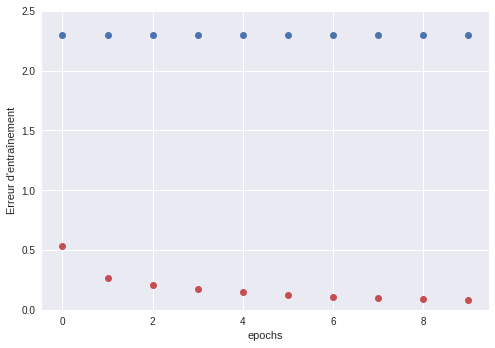

In [12]:
"""
#1 

Paramètres partager:

  - dimension des couches = (500,1000) ce qui donne un total de 903510 paramètres (784*500+500+500*1000+1000+1000*10+10=903510)
  - learning rate = 0.05
  - batch_size=100
  - activation function ReLU sauf pour la sortie qui est un softmax
  

"""
# initialisation à zéro
model1=NN(hidden_dims=(500,1000),option=1, l_starting_rate=0.05,l_down_rate=0 ,L1reg=0,L2reg=0, momentum=0, dropout=0 , batch_size=100, max_iter=10)
cost1=model1.train()

# initialisation Normale
model2=NN(hidden_dims=(500,1000),option=2, l_starting_rate=0.05,l_down_rate=0 ,L1reg=0,L2reg=0, momentum=0, dropout=0 , batch_size=100, max_iter=10)
cost2=model2.train()

# initialisation Glorot
model3=NN(hidden_dims=(500,1000),option=3, l_starting_rate=0.05,l_down_rate=0 ,L1reg=0,L2reg=0, momentum=0, dropout=0 , batch_size=100, max_iter=10)
cost3=model3.train()

x=np.arange(10)
plt.plot(x,cost1, 'o')
plt.plot(x,cost2, 'o')
plt.plot(x,cost3, 'o')
plt.ylim(0,2.5)
plt.xlabel("epochs")
plt.ylabel("Erreur d'entraînement")



(0, 2.5)

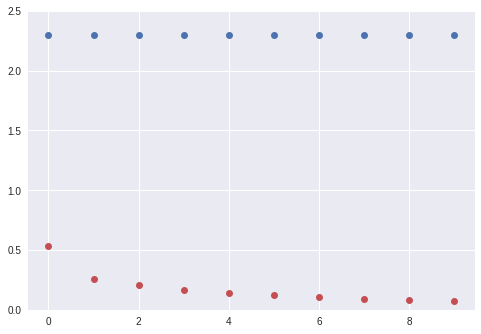

In [9]:
x=np.arange(10)
plt.plot(x,cost1, 'o')
plt.plot(x,cost2, 'o')
plt.plot(x,cost3, 'o')
plt.ylim(0,2.5)

In [0]:
#1 suite

"""

Test sur le dropout


"""

for i in range(3):
  dropout=0.2*i
  model3=NN(hidden_dims=(500,1000),option=3, l_starting_rate=0.1,l_down_rate=0.2 ,L1reg=0,L2reg=0, momentum=0, dropout=dropout , batch_size=100, max_iter=15)
  cost3=model3.train()
  print("dropout = ",dropout)

[[ 0.04695808  0.01491158  0.02112806 ... -0.02013108  0.03345728
  -0.05908795]
 [ 0.06132883 -0.03666456  0.0227906  ... -0.05162342 -0.03698251
  -0.04877786]
 [ 0.05583048  0.03087252 -0.00056959 ... -0.05433501  0.02844743
   0.03759454]
 ...
 [-0.05398653  0.0537284  -0.03978941 ... -0.02730532  0.06335652
   0.03661016]
 [ 0.02615801 -0.03285323 -0.06388836 ...  0.03540419 -0.03002602
  -0.01893265]
 [-0.03721233 -0.01747612  0.01952385 ... -0.04492023  0.00946627
   0.04752606]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
50000 10000 10000
0 499 100 0.41497215988574265 (0.2195485351626458, 93.89, 10000)
1 499 100 0.19145933227540674 (0.15357752001582406, 95.78999999999999, 10000)
2 499 100 0.13836100080363076 (0.12288706370018077, 96.56, 10000)
3 499 100 0.10781296904744479 (0.10672841382757886, 97.03, 10000)
4 499 100 0.08699546269549413 (0.09647319662438175, 97.28999999999999, 10000)
5 499 100 0.07159073915406629 (0.08968943393286263, 97.43, 10000)
6 499 100 

In [0]:
#1 suite

"""

Test sur les régularisations L1 et L2
L1 =  0.0 L2 =  0.0002


"""

for i in range(5):
  for j in range(5):
    model3=NN(hidden_dims=(500,1000),option=3, l_starting_rate=0.3,l_down_rate=0.2 ,L1reg=i*0.0002,L2reg=j*0.0002, momentum=0, dropout=0 , batch_size=100, max_iter=25)
    cost3=model3.train()
    print("L1 = ",i*0.0002,"L2 = ",j*0.0002)

0 499 100 0.31151325406151636 (0.14009877380413893, 95.85000000000001, 10000)
1 499 100 0.11639262990726218 (0.10401240120189989, 96.89999999999999, 10000)
2 499 100 0.07407040261964543 (0.088190251341161, 97.36, 10000)
3 499 100 0.05052748734042271 (0.08179603057868648, 97.55, 10000)
4 499 100 0.034726303914603955 (0.07919045198690666, 97.76, 10000)
5 499 100 0.023560056039980272 (0.07431261619364742, 97.91, 10000)
6 499 100 0.014547361064365516 (0.07093780289546125, 98.1, 10000)
7 499 100 0.011092597901758186 (0.07050535748998091, 98.13, 10000)
8 499 100 0.009025245368168738 (0.07000263182540194, 98.15, 10000)
9 499 100 0.007583720964361982 (0.06982392593600646, 98.17, 10000)
10 499 100 0.006514813046100893 (0.06966882867710117, 98.18, 10000)
11 499 100 0.00569423403133014 (0.06973257226572152, 98.2, 10000)
12 499 100 0.005065069000332111 (0.06981362391194162, 98.22, 10000)
13 499 100 0.004546211191539982 (0.0698653764667237, 98.2, 10000)
14 499 100 0.004137701561840245 (0.0700377569

In [10]:
#1 suite

"""

Test sur le momemtum


"""

for i in range(3):
  momentum=i*0.3
  model3=NN(hidden_dims=(500,1000),option=3, l_starting_rate=0.3,l_down_rate=0.2 ,L1reg=0,L2reg=0.0002, momentum=momentum, dropout=0 , batch_size=100, max_iter=25)
  cost3=model3.train()
  print("momentum = ",i*0.3)

epochs:  0   mean lost:  0.31178745177060985 accuracy:  (0.14267327672752644, 96.0, 10000)
epochs:  1   mean lost:  0.12089496620585286 accuracy:  (0.10839986207848251, 96.93, 10000)
epochs:  2   mean lost:  0.08100225417071506 accuracy:  (0.09535866448841332, 97.1, 10000)
epochs:  3   mean lost:  0.060741467355056596 accuracy:  (0.08618076891745066, 97.45, 10000)
epochs:  4   mean lost:  0.04651661427949189 accuracy:  (0.08256767503651789, 97.53, 10000)
epochs:  5   mean lost:  0.03623947808853653 accuracy:  (0.07940979153983578, 97.61999999999999, 10000)
epochs:  6   mean lost:  0.025588449088750333 accuracy:  (0.06580595670601566, 98.06, 10000)
epochs:  7   mean lost:  0.021960044063546978 accuracy:  (0.06483478485799225, 98.08, 10000)
epochs:  8   mean lost:  0.019746572926516822 accuracy:  (0.06401007979677781, 98.08, 10000)
epochs:  9   mean lost:  0.018169989608127584 accuracy:  (0.06346456792377377, 98.1, 10000)
epochs:  10   mean lost:  0.016937012143665376 accuracy:  (0.06297

[7.27456743e-03 9.70065190e-04 4.47513910e-06 4.47511717e-07
 4.47583312e-08]
[7.27456743e-03 9.70065190e-04 4.47513910e-06 4.47511717e-07
 4.47583312e-08]


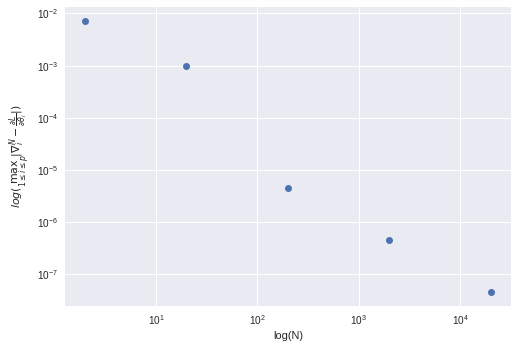

In [15]:
model_dif_fini=NN(hidden_dims=(500,1000),option=3, l_starting_rate=0.1,l_down_rate=0.2 ,L1reg=0,L2reg=0, momentum=0, dropout=0 , batch_size=100, max_iter=15)
y_dif_fini = model_dif_fini.dif_fini()
x=np.arange(5)
x=(2*10**x)
plt.loglog(x,y_dif_fini,'o')
plt.xlabel("log(N)")
plt.ylabel(r"$log(\max_{1 \leq i \leq p} |\nabla^N_i - \frac{\partial L}{\partial \theta_i}|)$")
print(y_dif_fini)